In [1]:
# imports 

# make notebook span full width of window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0] + "Dragonfly44_SFH/" # hack, but works
path_data = path_base+ "data/"

import numpy as np


In [13]:
# files with DF44 data

phot_file = path_data+"DF44/photometry.txt"

specKCWI_file_smoothed = path_data+"DF44/Villaume2022_KCWI/df44_optimal_cl_avg_110kms_new_bad_pix_interp_fixb.dat"

zobs = 0.02142

# filename of output, containing a dictionary of DF44 data prepared 
# as input into Prospector
obs_file = path_data+"DF44/obs_phot_specKCWI_sigma110.h5"


In [ ]:
#  initialize obs dictionary
obs = {}

obs['Redshift'] = zobs
# obs['mass'] = 1.6e11 # from wikipedia, not used

In [3]:
# read photometry

import pandas as pd 

phot_table = pd.read_csv(phot_file, names=["filternames","mAB","mAB_unc","units"])


In [4]:
# Prospector takes input fluxes in units of maggies
# convert from AB magnitudes

from Dragonfly44_SFH.utils import phot_conversions

phot_table['maggies']     = phot_conversions.get_maggie( mAB=phot_table['mAB'] )
phot_table['maggies_unc'] = phot_conversions.get_maggie_unc( mAB=phot_table['mAB'], mAB_unc=phot_table['mAB_unc'] )

https://www.eso.org/~ohainaut/ccd/sn.html

$ m = -2.5 \log S $

$ \sigma_m = -2.5 \log (S) + 2.5 \log (S+N) = 2.5 \log \left(\frac{S+N}{S}\right) = 2.5 \log \left(1 + \frac{1}{SNR}\right) $

$ SNR = \left( 10^{0.4~\sigma_m} - 1 \right)^{-1} $

In [5]:
# just to check, calculate the signal-to-noise

# approximation
phot_table['snr'] = phot_table['maggies'] / phot_table['maggies_unc']

# the long way
phot_table['snr2'] = 1./( 10**(0.4*phot_table['mAB_unc']) - 1)

In [6]:
# display table
phot_table

,filternames,mAB,mAB_unc,units,maggies,maggies_unc,snr,snr2
0,wfc3_uvis_f606w,19.80,0.08,ABmag,1.202264e-08,8.858612e-10,13.571703,13.077842
1,wfc3_uvis_f814w,19.32,0.19,ABmag,1.870682e-08,3.273628e-09,5.714401,5.228977
2,gmos_n_g_G0301,20.02,0.14,ABmag,9.817479e-09,1.265913e-09,7.755259,7.266001
3,gmos_n_i_G0302,19.33,0.18,ABmag,1.853532e-08,3.072898e-09,6.031868,5.545677
4,IRAC1,20.09,0.18,ABmag,9.204496e-09,1.525978e-09,6.031868,5.545677
5,IRAC2,20.45,0.24,ABmag,6.606934e-09,1.460451e-09,4.523901,4.042307
6,galex_NUV,23.67,0.35,ABmag,3.404082e-10,1.097346e-10,3.102103,2.628921
7,uvot_w2,24.97,0.41,ABmag,1.028016e-10,3.882036e-11,2.648137,2.179531
8,uvot_w1,23.40,0.19,ABmag,4.365158e-10,7.638873e-11,5.714401,5.228977


In [7]:

obs['filternames'] = phot_table['filternames']
from sedpy.observate import load_filters
phot_filters = load_filters( np.array( phot_table['filternames'], dtype=str) )
obs['filters'] = phot_filters

obs['phot_wave'] = np.array([ f.wave_effective for f in phot_filters ])

obs['maggies'] = phot_table['maggies']
obs['maggies_unc'] = phot_table['maggies_unc']

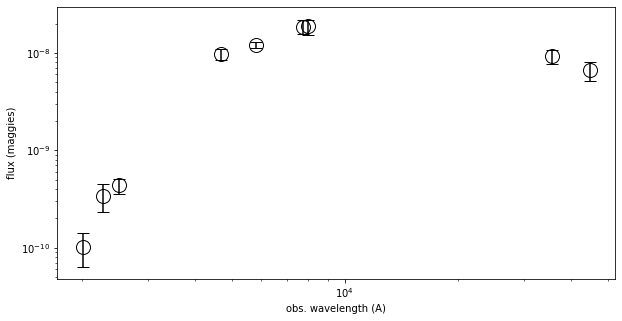

In [12]:
# plot photometry

fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.errorbar( obs['phot_wave'], obs['maggies'], yerr=obs['maggies_unc'], 
             fmt=' ', color='k', marker='o', ms=14, mec='k', mfc='None', capsize=6 )

ax.set( xscale='log', yscale='log', ylabel='flux (maggies)', xlabel='obs. wavelength (A)')
plt.show()

In [14]:
#  read in (smoothed) spectroscopy and add to obs dictionary
# smoothing is necessary since the model templates used 
# in Prospector have R=2.4 A (see "inres") as specified in FSPS manual
# note that KCWI spectrum resolution in km/s
# note template resolution in units A (convert to km/s)

# the spectrum has already had the continuum removed
x,y,ey,_,_ = np.loadtxt(specKCWI_file_smoothed, unpack=True)

# to aid spectro-photometry calibration, guess that spectrum
# should match photometry, normalize by factor
specnorm = 1e8

obs['sigma_smooth'] = 110 # km/s
obs['e_sigma_smooth'] = 10 # km/s, only relevant if sigma_smooth is free and using this to construct prior
obs['smoothtype'] = 'vel'
obs['inres'] = ( 3e5 ) * (2.5/2.355 / 5000) # 64 km/s


obs['wavelength'] = x
obs['spectrum'] = y /specnorm
obs['unc'] = ey /specnorm

In [15]:
# minimum and maximum observed wavelength included in the spectrum
x[0]/(1.+zobs), x[-1]/(1.+zobs)

(4578.487481711445, 5336.94721690957)

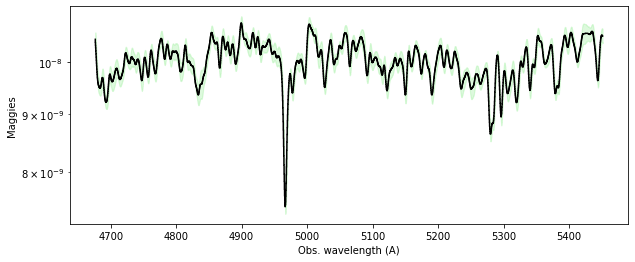

In [17]:
#
fig, ax = plt.subplots(1,1,figsize=(10,4))

# ax.errorbar( obs['phot_wave'], obs['maggies'], yerr=obs['maggies_unc'], fmt=' ', color='k', marker='o', ms=10, mec='k', mfc='None', capsize=3 )

ax.fill_between( obs['wavelength'], obs['spectrum']-obs['unc'], obs['spectrum']+obs['unc'], color='lightgreen', alpha=0.3, step='post' )
ax.step( obs['wavelength'], obs['spectrum'], color='k' )

ax.set( xscale='linear', yscale='log', ylabel='Maggies', xlabel='Obs. wavelength (A)')
plt.show()

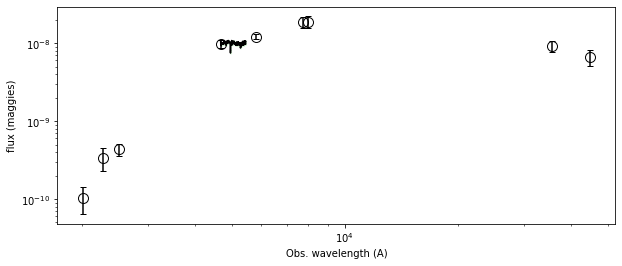

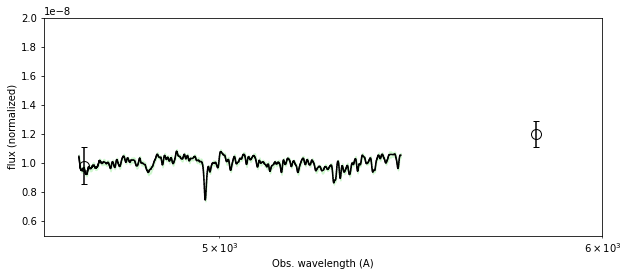

In [18]:
#
fig, ax = plt.subplots(1,1,figsize=(10,4))

ax.errorbar( obs['phot_wave'], obs['maggies'], yerr=obs['maggies_unc'], fmt=' ', color='k', marker='o', ms=10, mec='k', mfc='None', capsize=3 )

ax.fill_between( obs['wavelength'], obs['spectrum']-obs['unc'], obs['spectrum']+obs['unc'], color='lightgreen', alpha=0.3, step='post' )
ax.step( obs['wavelength'], obs['spectrum'], color='k' )

ax.set( xscale='log', yscale='log', ylabel='flux (maggies)', xlabel='Obs. wavelength (A)')
plt.show()

#
fig, ax = plt.subplots(1,1,figsize=(10,4))

ax.errorbar( obs['phot_wave'], obs['maggies'], yerr=obs['maggies_unc'], fmt=' ', color='k', marker='o', ms=10, mec='k', mfc='None', capsize=3 )

ax.fill_between( obs['wavelength'], obs['spectrum']-obs['unc'], obs['spectrum']+obs['unc'], color='lightgreen', alpha=0.3, step='post' )
ax.step( obs['wavelength'], obs['spectrum'], color='k' )

ax.set( xscale='log', yscale='linear', ylabel='flux (normalized)', xlabel='Obs. wavelength (A)')
ax.set( xlim=(4600,6000), ylim=(5e-9,2e-8))
plt.show()